In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
dfps_train = []
dfps_test = []

for dirname, _, filenames in os.walk('/kaggle/input/ddos2019'):
    for filename in filenames:
        if filename.endswith('-training.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_train.append(dfp)
            print(dfp)
        elif filename.endswith('-testing.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps_test.append(dfp)
            print(dfp)

/kaggle/input/ddos2019/Syn-training.parquet
/kaggle/input/ddos2019/UDPLag-testing.parquet
/kaggle/input/ddos2019/NetBIOS-testing.parquet
/kaggle/input/ddos2019/Portmap-training.parquet
/kaggle/input/ddos2019/Syn-testing.parquet
/kaggle/input/ddos2019/MSSQL-testing.parquet
/kaggle/input/ddos2019/SNMP-testing.parquet
/kaggle/input/ddos2019/UDPLag-training.parquet
/kaggle/input/ddos2019/NTP-testing.parquet
/kaggle/input/ddos2019/LDAP-testing.parquet
/kaggle/input/ddos2019/UDP-training.parquet
/kaggle/input/ddos2019/NetBIOS-training.parquet
/kaggle/input/ddos2019/DNS-testing.parquet
/kaggle/input/ddos2019/UDP-testing.parquet
/kaggle/input/ddos2019/LDAP-training.parquet
/kaggle/input/ddos2019/TFTP-testing.parquet
/kaggle/input/ddos2019/MSSQL-training.parquet


In [3]:
train_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_train]
test_prefixes = [dfp.split('/')[-1].split('-')[0] for dfp in dfps_test]

common_prefixes = list(set(train_prefixes).intersection(test_prefixes))

# Filter the dataframes to only include the common prefixes
dfps_train = [dfp for dfp in dfps_train if dfp.split('/')[-1].split('-')[0] in common_prefixes]
dfps_test = [dfp for dfp in dfps_test if dfp.split('/')[-1].split('-')[0] in common_prefixes]

In [4]:
train_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_train], ignore_index=True)
test_df = pd.concat([pd.read_parquet(dfp) for dfp in dfps_test], ignore_index=True)

In [5]:
train_df.shape, test_df.shape


((120065, 78), (38973, 78))

In [6]:
train_df.head()

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,105,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn
1,6,1,2,0,12.0,0.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn
2,6,55295858,8,0,48.0,0.0,6.0,6.0,6.0,0.0,...,20,1.0,0.0,1.0,1.0,18431952.0,4641289.0,22000140.0,13184826.0,Syn
3,6,49,2,0,12.0,0.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn
4,6,109,2,2,12.0,12.0,6.0,6.0,6.0,0.0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Syn


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120065 entries, 0 to 120064
Data columns (total 78 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  120065 non-null  int8   
 1   Flow Duration             120065 non-null  int32  
 2   Total Fwd Packets         120065 non-null  int32  
 3   Total Backward Packets    120065 non-null  int16  
 4   Fwd Packets Length Total  120065 non-null  float32
 5   Bwd Packets Length Total  120065 non-null  float32
 6   Fwd Packet Length Max     120065 non-null  float32
 7   Fwd Packet Length Min     120065 non-null  float32
 8   Fwd Packet Length Mean    120065 non-null  float32
 9   Fwd Packet Length Std     120065 non-null  float32
 10  Bwd Packet Length Max     120065 non-null  float32
 11  Bwd Packet Length Min     120065 non-null  float32
 12  Bwd Packet Length Mean    120065 non-null  float32
 13  Bwd Packet Length Std     120065 non-null  f

In [8]:
train_df.describe()


,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Act Data Packets,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,120065.000000,1.200650e+05,120065.000000,120065.000000,120065.000000,1.200650e+05,120065.000000,120065.000000,120065.000000,120065.000000,...,120065.000000,1.200650e+05,1.200650e+05,1.200650e+05,1.200650e+05,1.200650e+05,120065.0,120065.00,120065.0,120065.0
mean,9.847882,2.052619e+07,9.494665,5.229134,793.607422,2.857971e+03,193.468842,124.397636,139.754761,23.783619,...,5.671170,-1.248534e+07,7.801129e+04,7.839450e+04,1.821768e+05,3.275870e+04,6264210.0,1559991.25,7932698.5,4813855.5
std,5.306882,2.995552e+07,356.316717,46.543910,2773.379639,7.458964e+04,362.704865,250.974854,255.355026,89.604317,...,19.933391,1.145488e+08,4.513395e+05,3.854388e+05,8.239448e+05,3.747193e+05,10542134.0,3189901.75,12431808.0,9487713.0
min,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.408238e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.00,0.0,0.0
25%,6.000000,4.110000e+02,2.000000,0.000000,36.000000,0.000000e+00,6.000000,6.000000,6.000000,0.000000,...,1.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.00,0.0,0.0
50%,6.000000,1.096240e+05,4.000000,2.000000,72.000000,1.200000e+01,6.000000,6.000000,6.000000,0.000000,...,3.000000,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.00,0.0,0.0
75%,17.000000,4.531427e+07,10.000000,4.000000,1076.000000,3.600000e+01,388.000000,52.000000,262.511108,7.905694,...,7.000000,2.000000e+01,3.766667e+01,3.323402e+01,1.010000e+02,1.000000e+00,12203672.0,2413746.50,15799887.0,7754443.0
max,17.000000,1.199975e+08,86666.000000,8029.000000,208524.000000,1.289243e+07,3625.000000,2131.000000,2131.000000,1448.583008,...,3888.000000,6.724045e+07,4.050800e+07,1.063756e+07,4.050800e+07,4.050800e+07,117569200.0,69614024.00,117569200.0,117569200.0


In [9]:
# Check the target distribution of the training data
train_df["Label"].value_counts()

Label
Syn        48840
Benign     42007
UDP        18090
MSSQL       8523
LDAP        1906
NetBIOS      644
UDPLag        55
Name: count, dtype: int64

In [10]:
test_df["Label"].value_counts()

Label
Benign           10847
DrDoS_UDP        10420
UDP-lag           8872
DrDoS_MSSQL       6212
DrDoS_LDAP        1440
DrDoS_NetBIOS      598
Syn                533
WebDDoS             51
Name: count, dtype: int64

In [11]:
# Drop the WebDDoS class from the testing data
test_df = test_df[test_df["Label"] != "WebDDoS"]

In [12]:
# Map the labels to the same format
label_mapping = {
    'DrDoS_UDP': 'UDP',
    'UDP-lag': 'UDPLag',
    'DrDoS_MSSQL': 'MSSQL',
    'DrDoS_LDAP': 'LDAP',
    'DrDoS_NetBIOS': 'NetBIOS',
    'Syn': 'Syn',  # Already matches
    'Benign': 'Benign'  # Already matches
}

test_df["Label"] = test_df["Label"].map(label_mapping)



In [13]:
# Check the target distribution of the testing data
test_df["Label"].value_counts()

Label
Benign     10847
UDP        10420
UDPLag      8872
MSSQL       6212
LDAP        1440
NetBIOS      598
Syn          533
Name: count, dtype: int64

In [14]:
# Display the columns of the training data
train_df.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [ ]:
columns_to_normalize = ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets']
scaler = MinMaxScaler()
train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
if not test_df.empty:
    test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])

In [ ]:
from sklearn.decomposition import PCA
X_train = train_df.drop(columns=["Label"])
y_train = train_df["Label"]

pca = PCA(n_components=10)  
X_train_pca = pca.fit_transform(X_train)



In [15]:
def grab_col_names(data, cat_th=10, car_th=20):

    # Categorical columns and categorical but high-cardinality columns
    cat_cols = [col for col in data.columns if data[col].dtypes == "O"]
    num_but_cat = [col for col in data.columns if data[col].nunique() < cat_th and data[col].dtypes != "O"]
    high_card_cat_cols = [col for col in data.columns if data[col].nunique() > car_th and data[col].dtypes == "O"]

    # Combine Object type columns and Low-unique-value numeric columns into cat_cols
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in high_card_cat_cols]

    # Numerical columns excluding those considered as categorical
    num_cols = [col for col in data.columns if data[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Display information about the dataset
    print(f"Observations: {data.shape[0]}")
    print(f"Variables: {data.shape[1]}")
    print(f"Categorical Columns: {len(cat_cols)}")
    print(f"Numerical Columns: {len(num_cols)}")
    print(f"High Cardinality Categorical Columns: {len(high_card_cat_cols)}")
    print(f"Number but Categorical Columns: {len(num_but_cat)}")
    print("\n")

    return cat_cols, num_cols, high_card_cat_cols

cat_cols, num_cols, high_card_cat_cols = grab_col_names(train_df)
print(f"Catergorical Columns: {cat_cols}")
print(f"Numerical Columns: {num_cols}")
print(f"High Cardinality Categorical Columns: {high_card_cat_cols}")

Observations: 120065
Variables: 78
Categorical Columns: 20
Numerical Columns: 58
High Cardinality Categorical Columns: 0
Number but Categorical Columns: 19


Catergorical Columns: ['Label', 'Protocol', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'FIN Flag Count', 'SYN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count', 'CWE Flag Count', 'ECE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Numerical Columns: ['Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Fwd Packets Length Total', 'Bwd Packets Length Total', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT To

In [16]:
for i in cat_cols:
    print(i, train_df[i].unique())

Label ['Syn' 'Benign' 'UDP' 'UDPLag' 'MSSQL' 'NetBIOS' 'LDAP']
Protocol [ 6 17  0]
Fwd PSH Flags [0 1]
Bwd PSH Flags [0]
Fwd URG Flags [0]
Bwd URG Flags [0]
FIN Flag Count [0]
SYN Flag Count [0 1]
RST Flag Count [0 1]
PSH Flag Count [0]
ACK Flag Count [1 0]
URG Flag Count [0 1]
CWE Flag Count [0 1]
ECE Flag Count [0]
Fwd Avg Bytes/Bulk [0]
Fwd Avg Packets/Bulk [0]
Fwd Avg Bulk Rate [0]
Bwd Avg Bytes/Bulk [0]
Bwd Avg Packets/Bulk [0]
Bwd Avg Bulk Rate [0]


In [17]:
# Display the columns with only one unique value
for i in train_df.columns:
    if train_df[i].nunique() == 1:
        print(i)

Bwd PSH Flags
Fwd URG Flags
Bwd URG Flags
FIN Flag Count
PSH Flag Count
ECE Flag Count
Fwd Avg Bytes/Bulk
Fwd Avg Packets/Bulk
Fwd Avg Bulk Rate
Bwd Avg Bytes/Bulk
Bwd Avg Packets/Bulk
Bwd Avg Bulk Rate


In [18]:
print(f"Total number of missing values: {train_df.isnull().sum().sum()}")

Total number of missing values: 0


In [19]:
print(f"Number of Duplicate Rows: {train_df.duplicated().sum()}")

Number of Duplicate Rows: 3195


In [20]:
train_df = train_df.drop_duplicates()

         Label      Ratio
Label                    
Syn      47246  40.426114
Benign   40980  35.064602
UDP      17795  15.226320
MSSQL     8434   7.216565
LDAP      1885   1.612903
NetBIOS    475   0.406434
UDPLag      55   0.047061




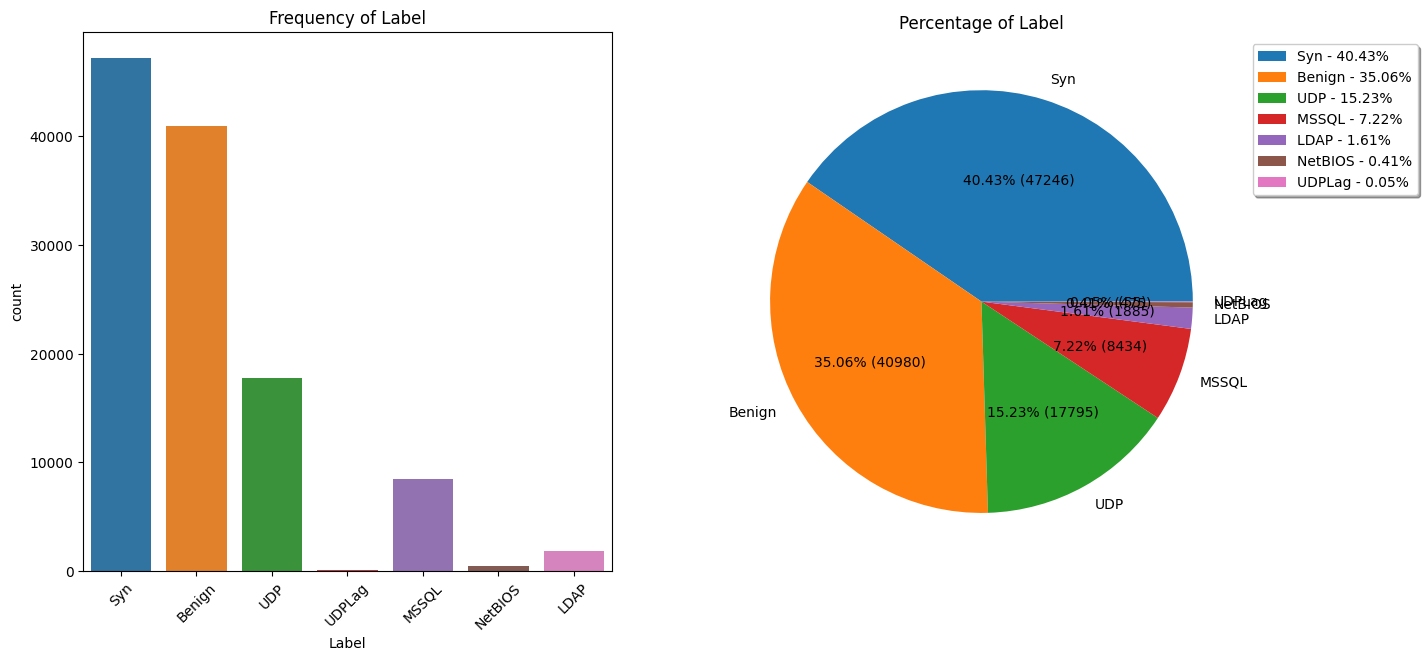

          Protocol      Ratio
Protocol                     
6            74330  63.600582
17           41807  35.772226
0              733   0.627193




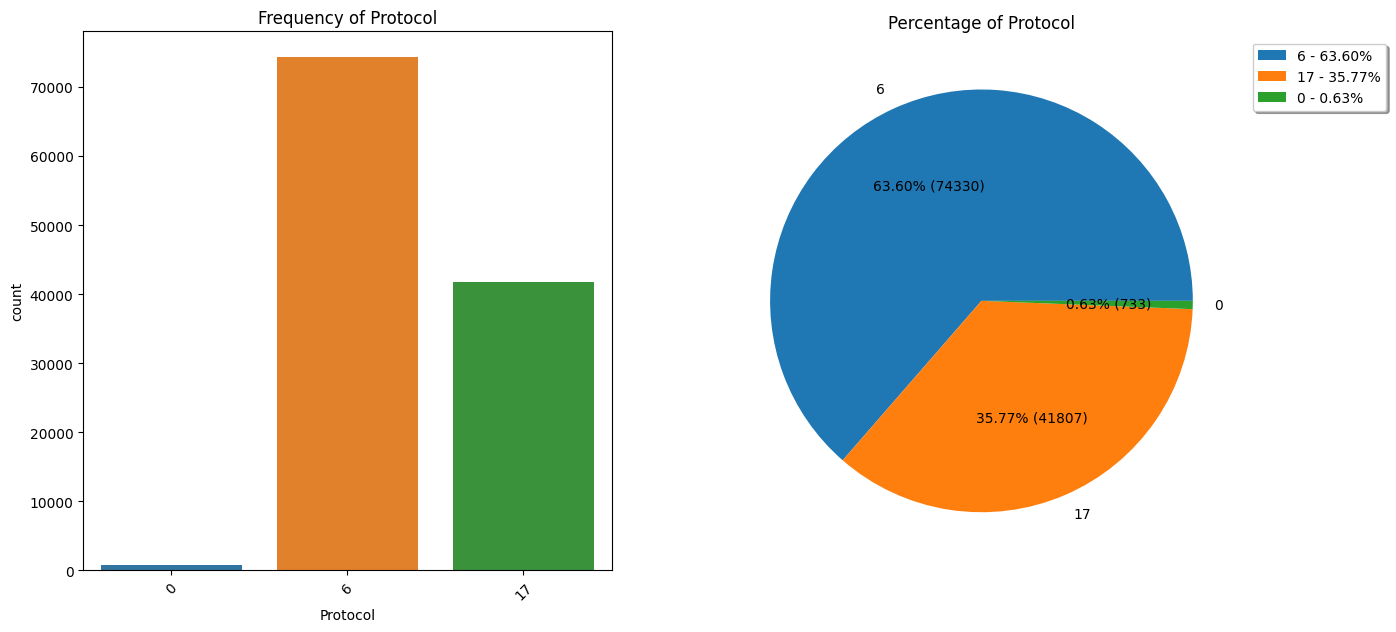

               Fwd PSH Flags      Ratio
Fwd PSH Flags                          
0                     111549  95.447078
1                       5321   4.552922




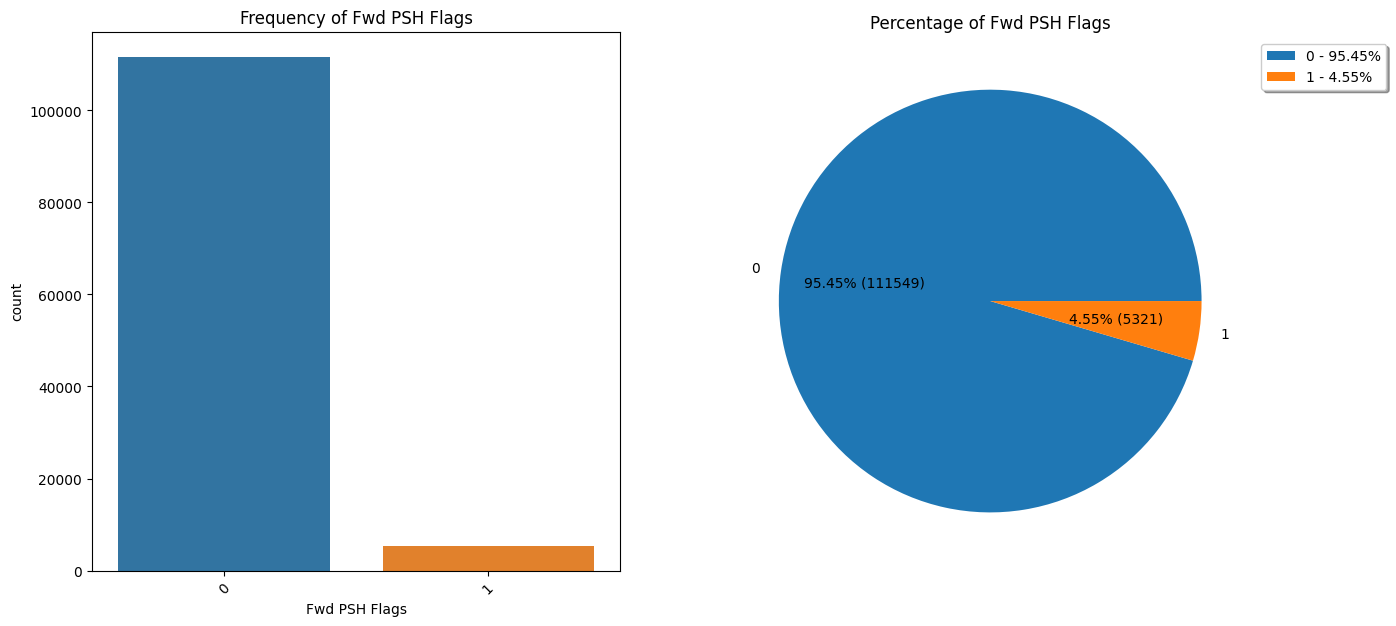

               Bwd PSH Flags  Ratio
Bwd PSH Flags                      
0                     116870  100.0




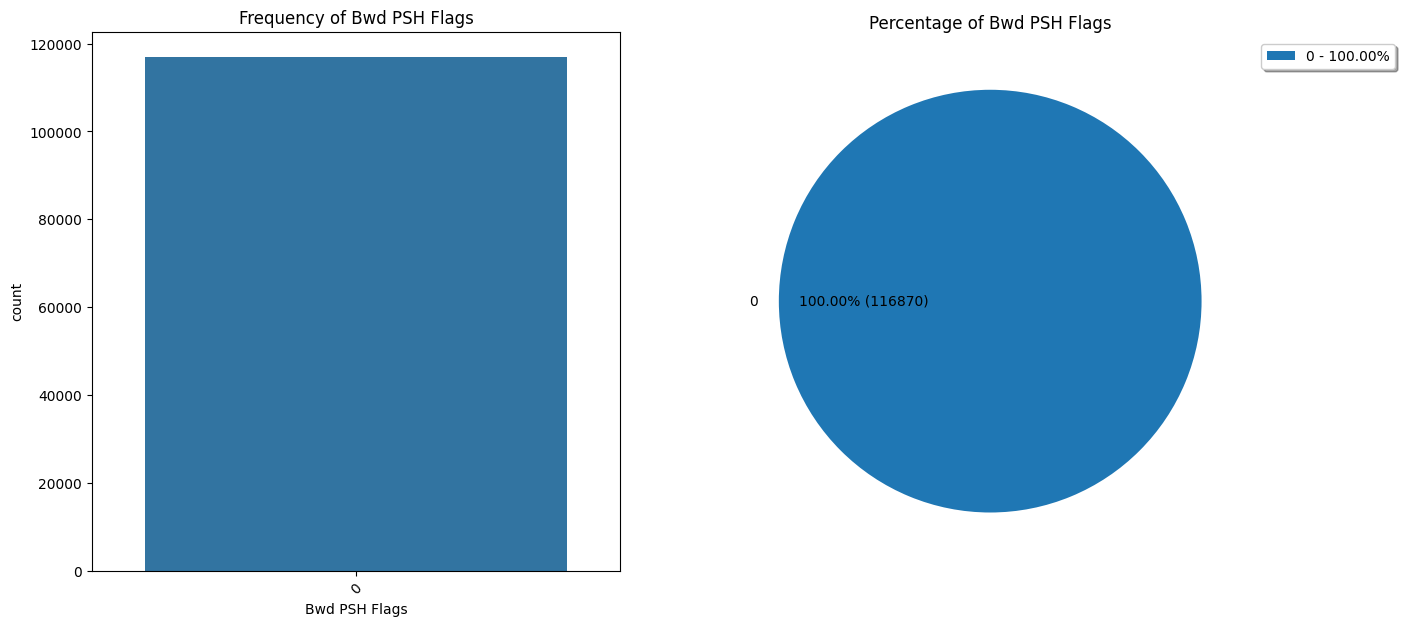

               Fwd URG Flags  Ratio
Fwd URG Flags                      
0                     116870  100.0




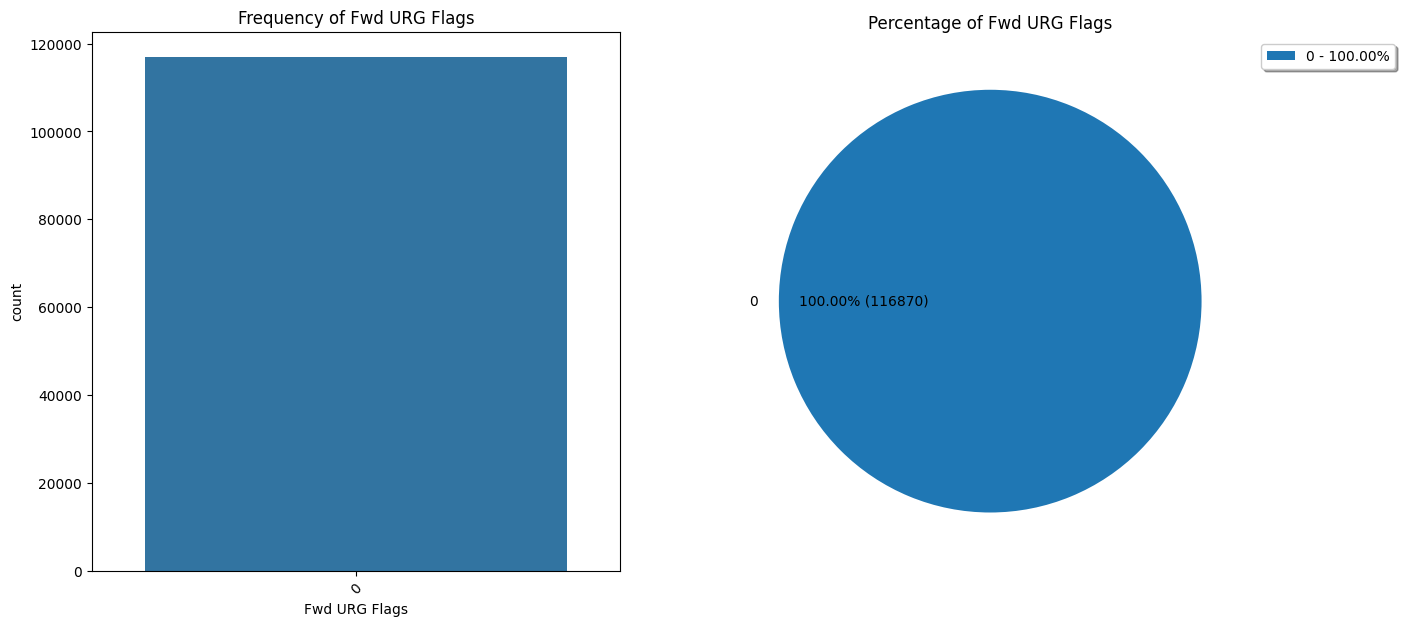

               Bwd URG Flags  Ratio
Bwd URG Flags                      
0                     116870  100.0




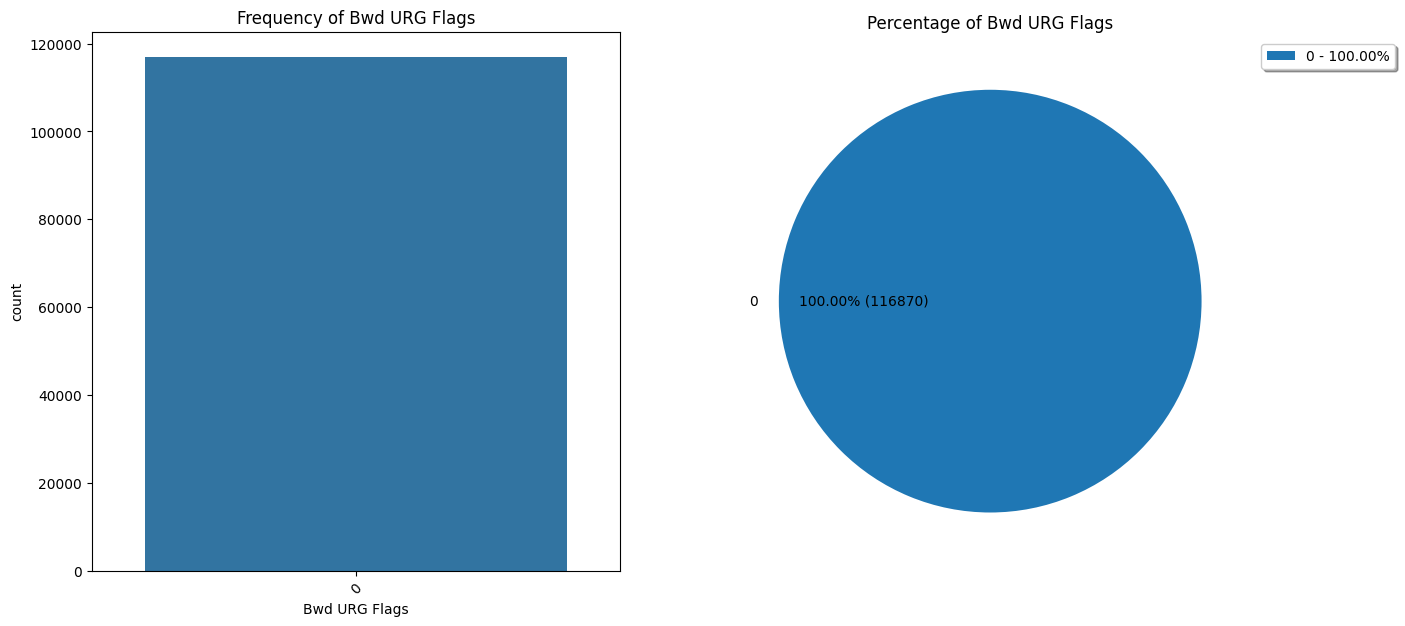

                FIN Flag Count  Ratio
FIN Flag Count                       
0                       116870  100.0




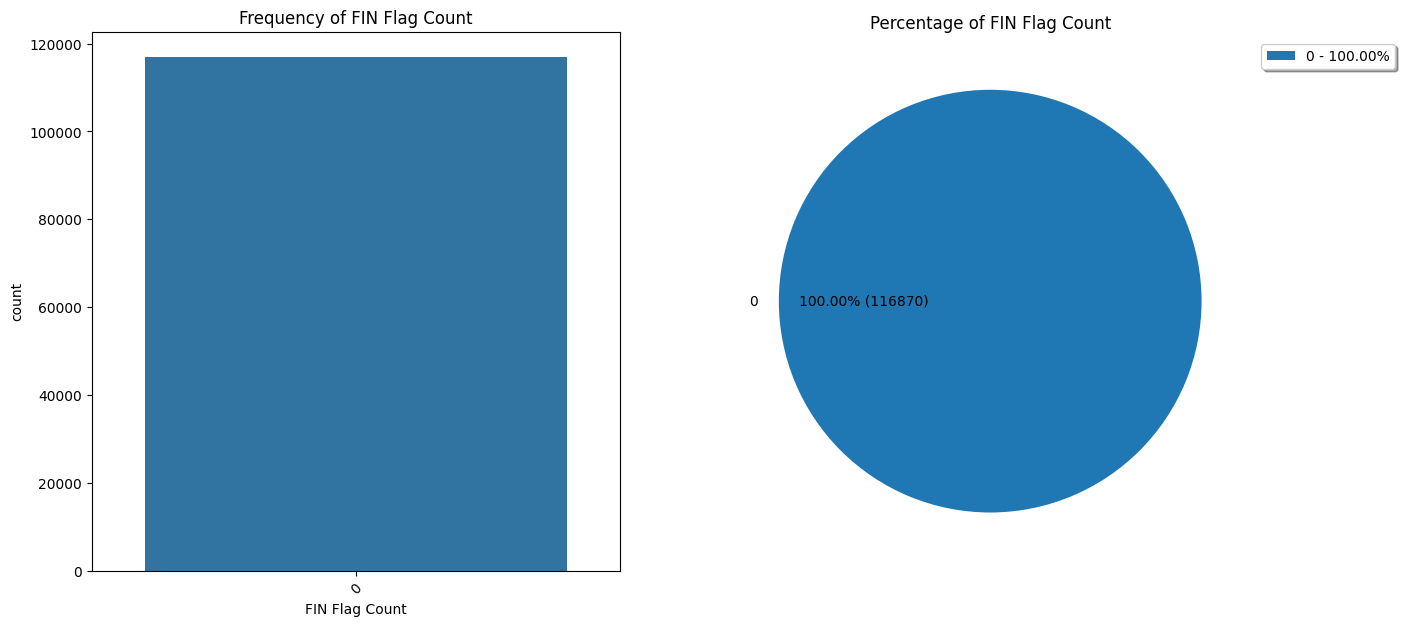

                SYN Flag Count      Ratio
SYN Flag Count                           
0                       116773  99.917002
1                           97   0.082998




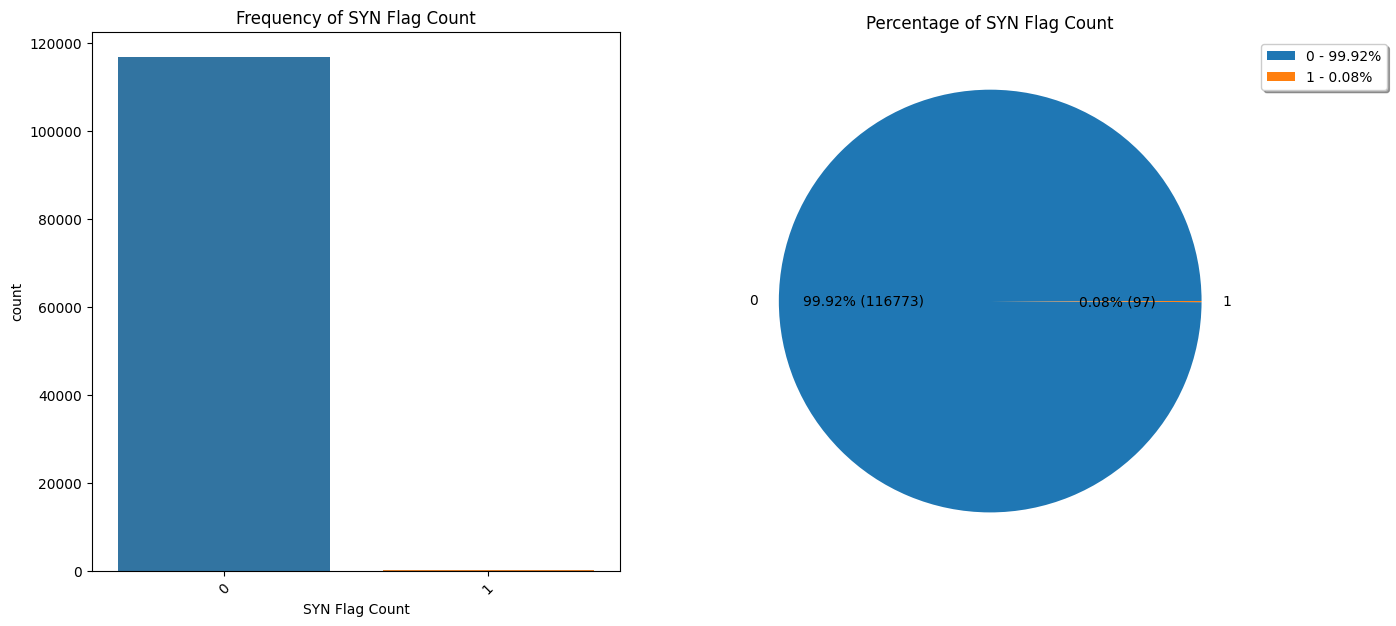

                RST Flag Count      Ratio
RST Flag Count                           
0                       111549  95.447078
1                         5321   4.552922




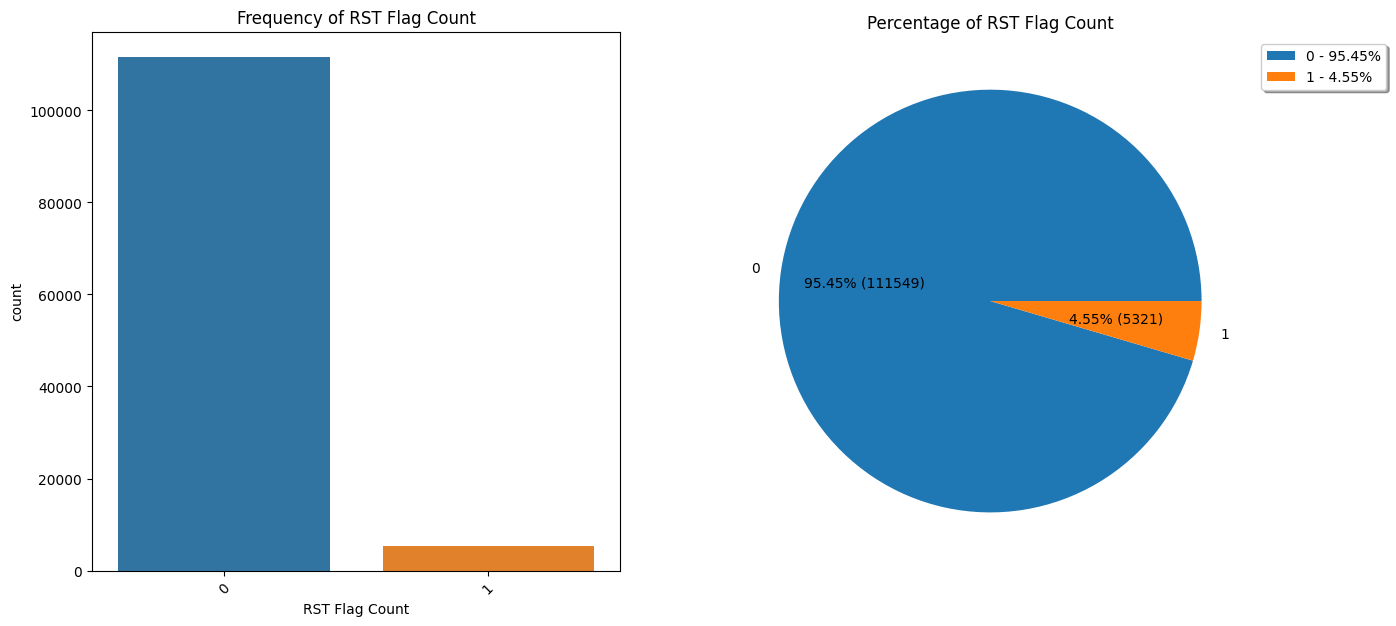

                PSH Flag Count  Ratio
PSH Flag Count                       
0                       116870  100.0




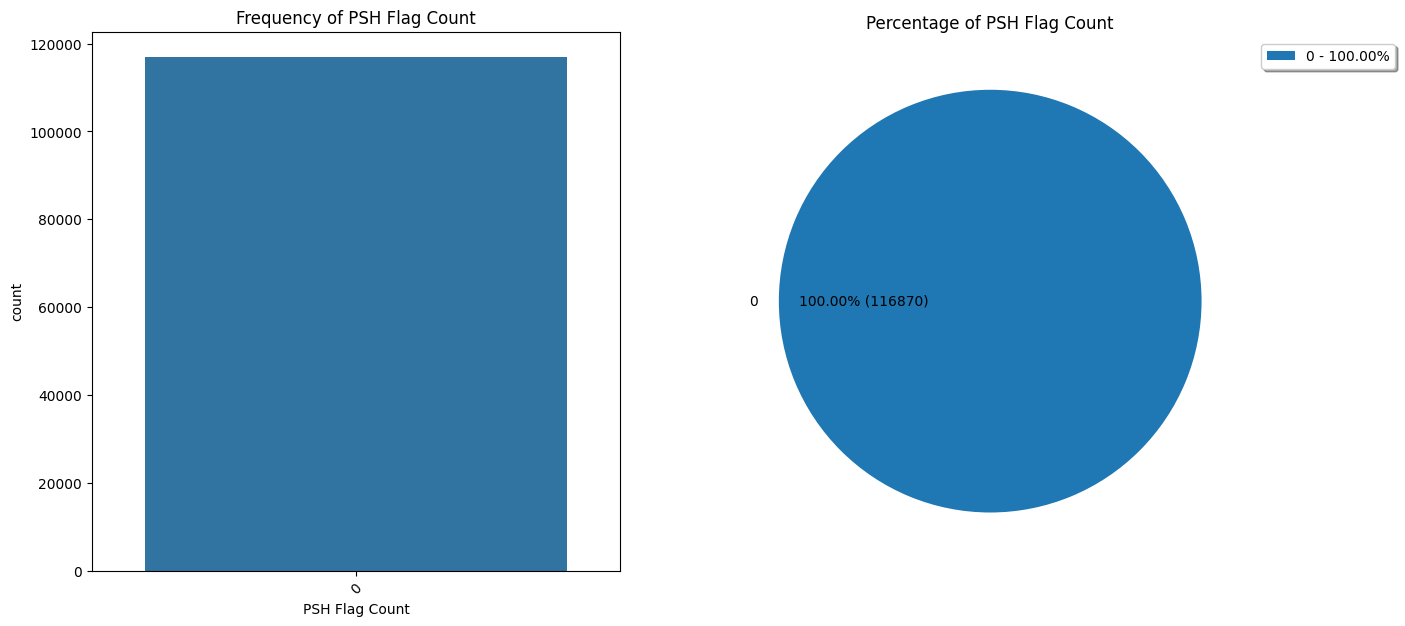

                ACK Flag Count      Ratio
ACK Flag Count                           
0                        60525  51.788312
1                        56345  48.211688




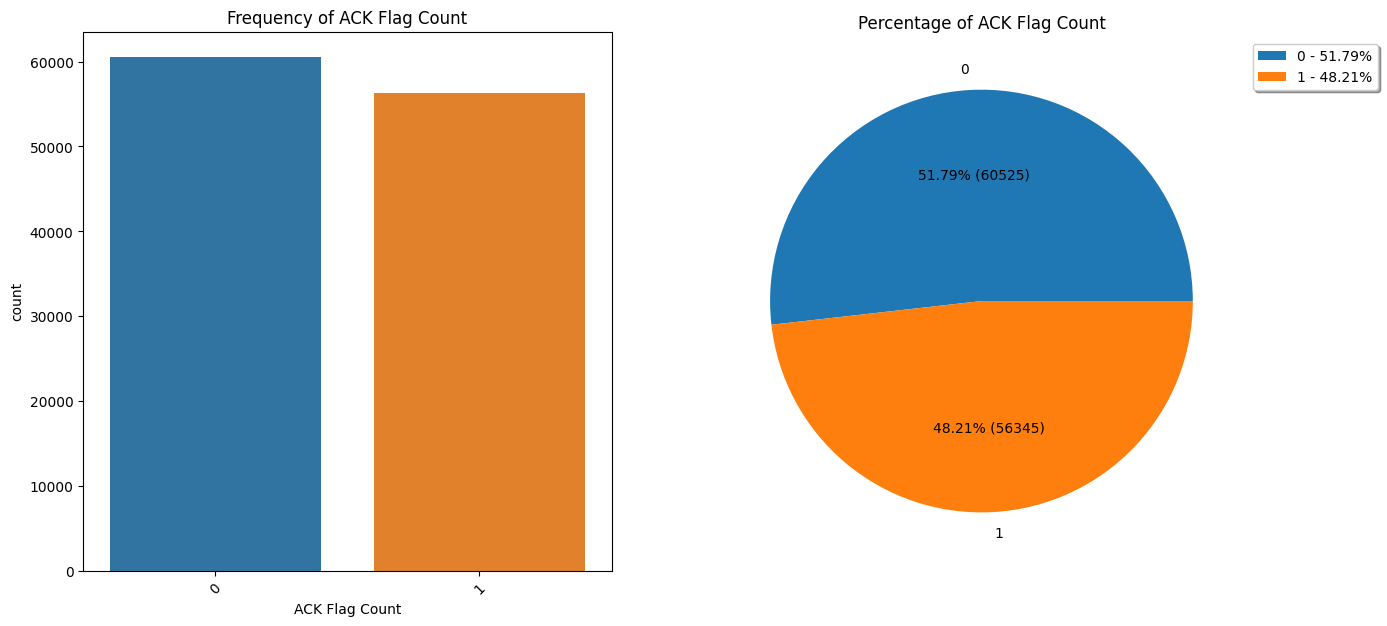

                URG Flag Count      Ratio
URG Flag Count                           
0                        98885  84.611106
1                        17985  15.388894




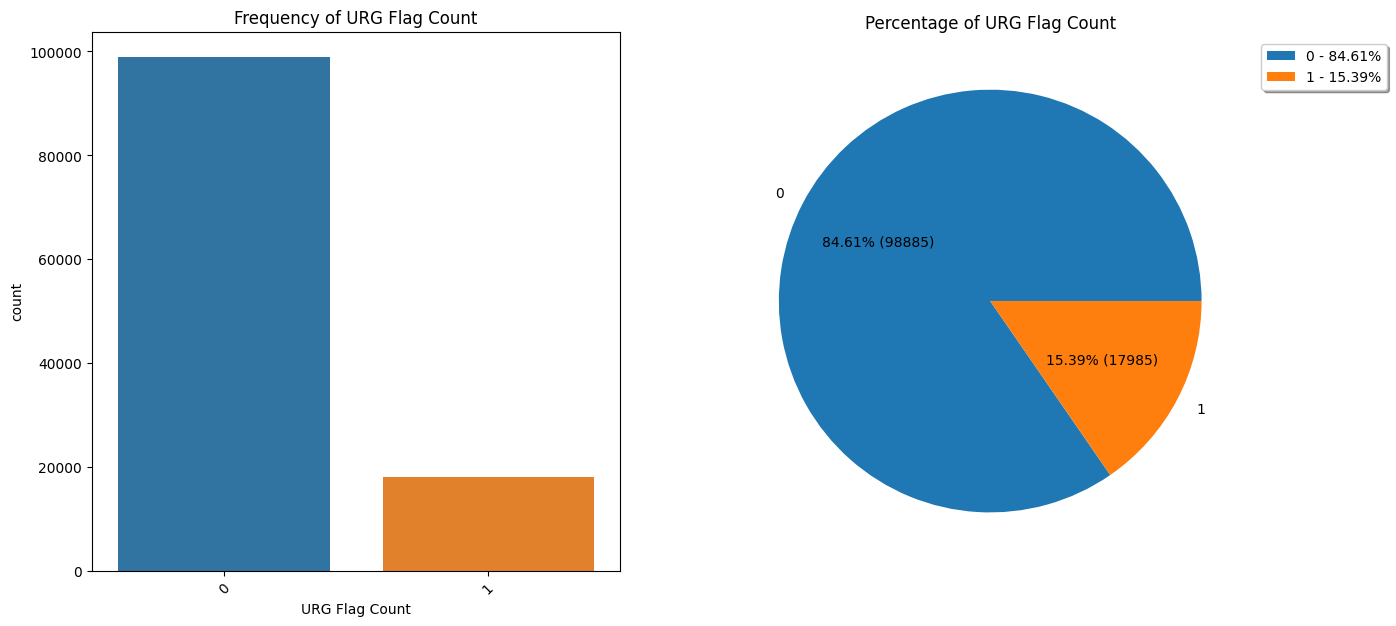

                CWE Flag Count      Ratio
CWE Flag Count                           
0                       107769  92.212715
1                         9101   7.787285




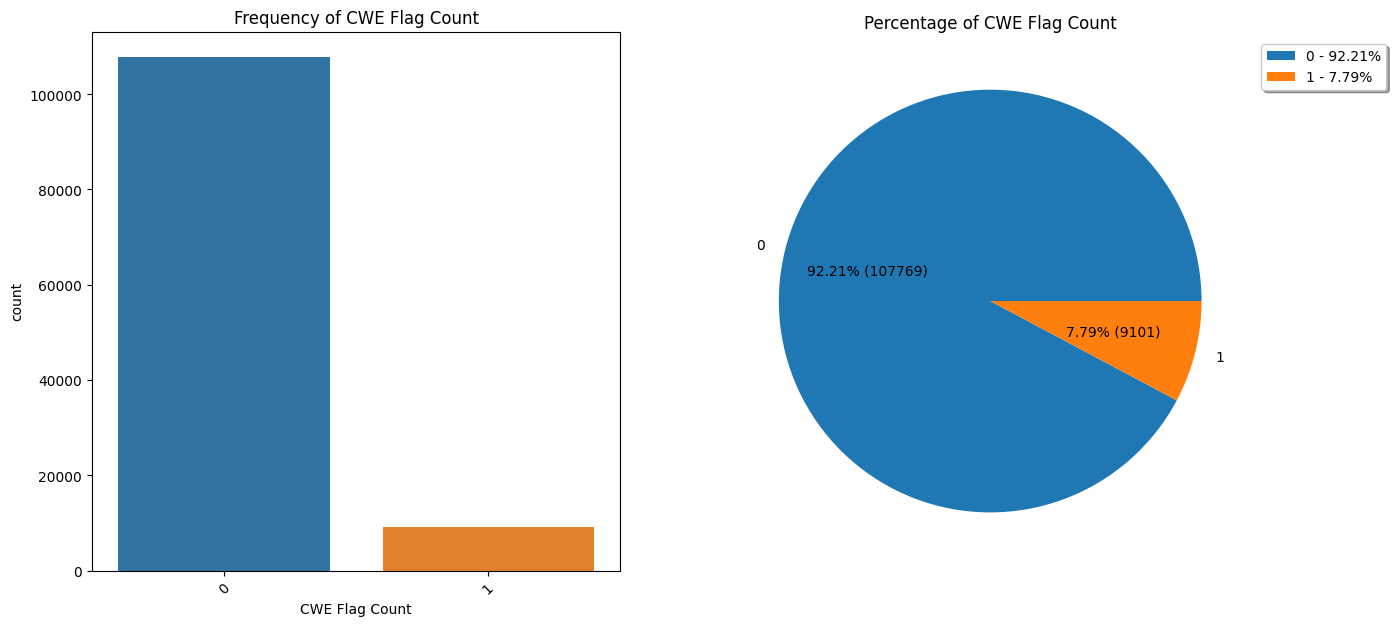

                ECE Flag Count  Ratio
ECE Flag Count                       
0                       116870  100.0




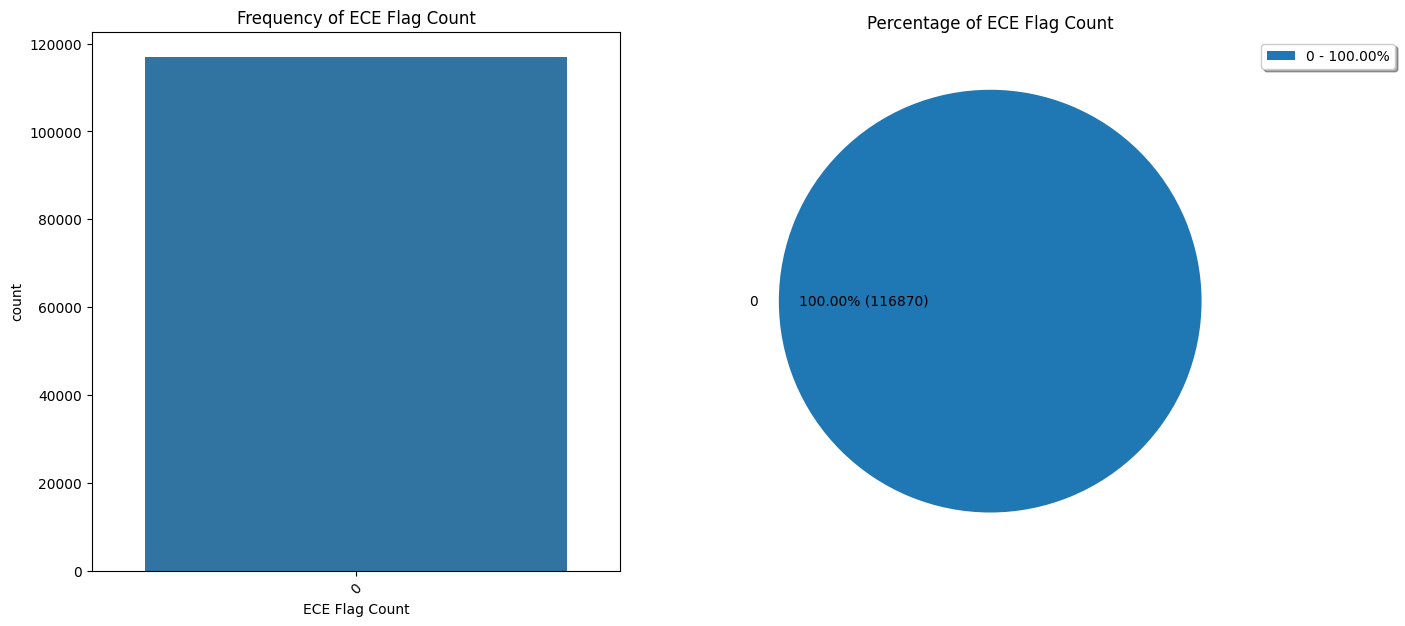

                    Fwd Avg Bytes/Bulk  Ratio
Fwd Avg Bytes/Bulk                           
0                               116870  100.0




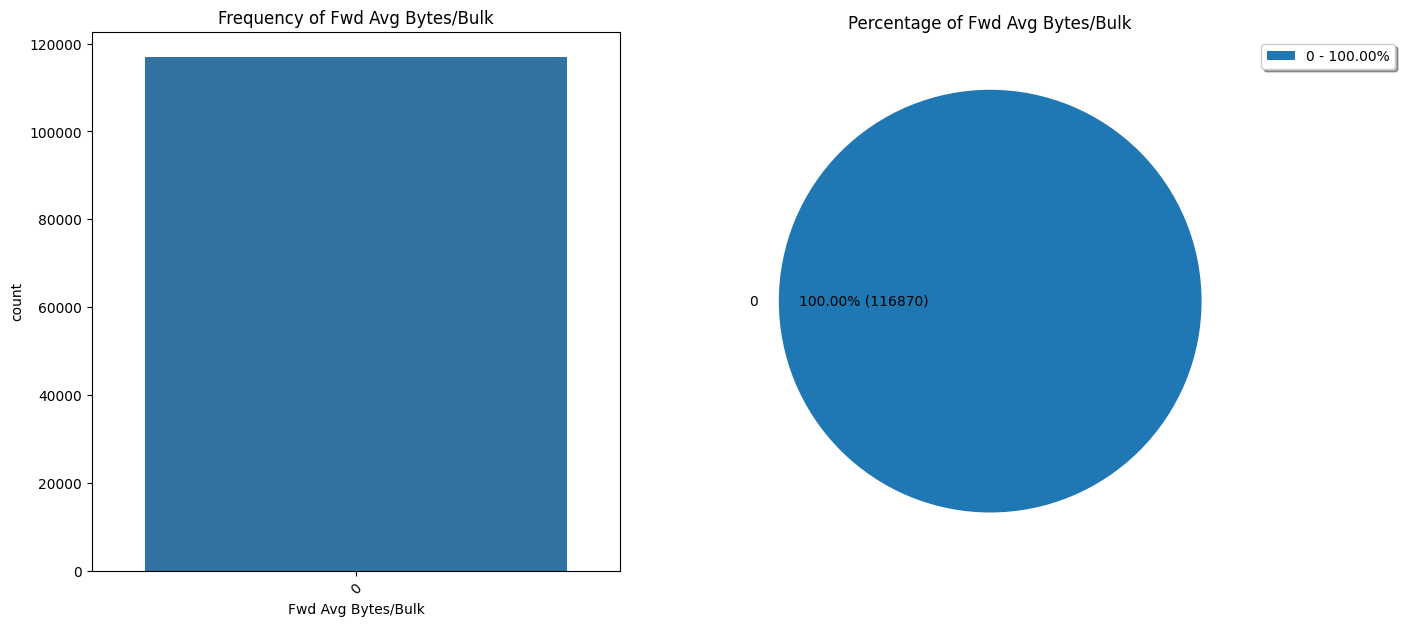

                      Fwd Avg Packets/Bulk  Ratio
Fwd Avg Packets/Bulk                             
0                                   116870  100.0




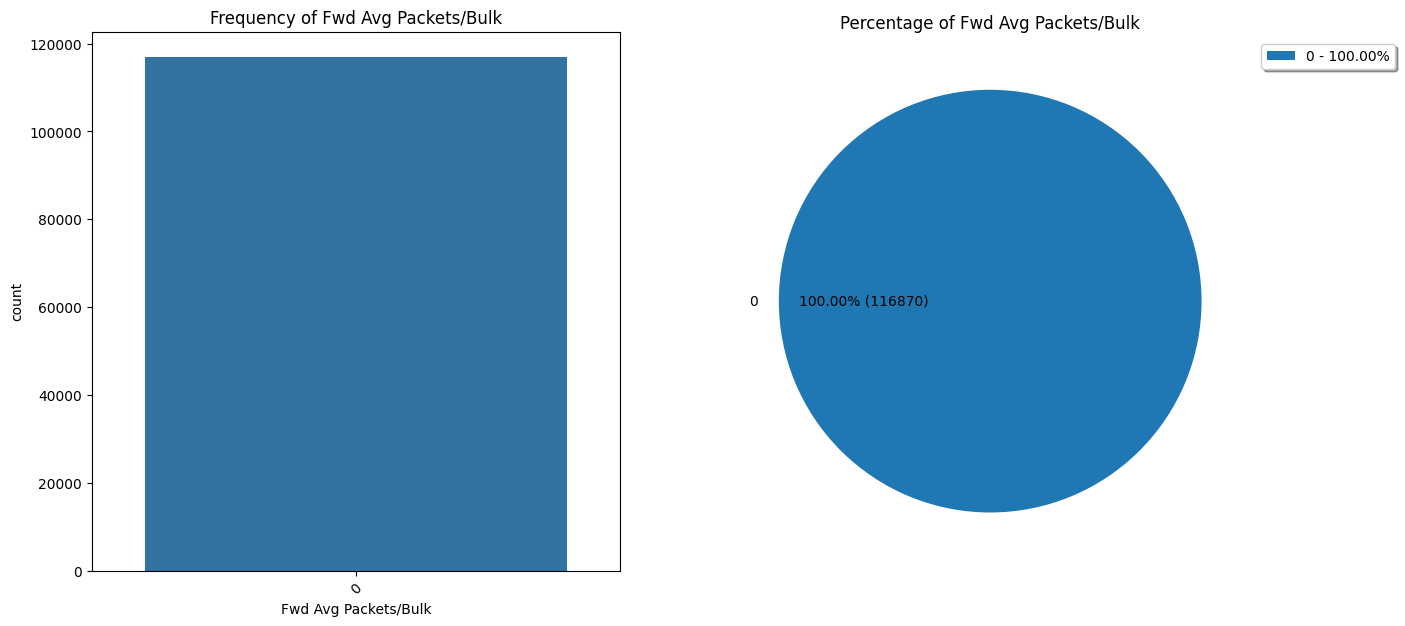

                   Fwd Avg Bulk Rate  Ratio
Fwd Avg Bulk Rate                          
0                             116870  100.0




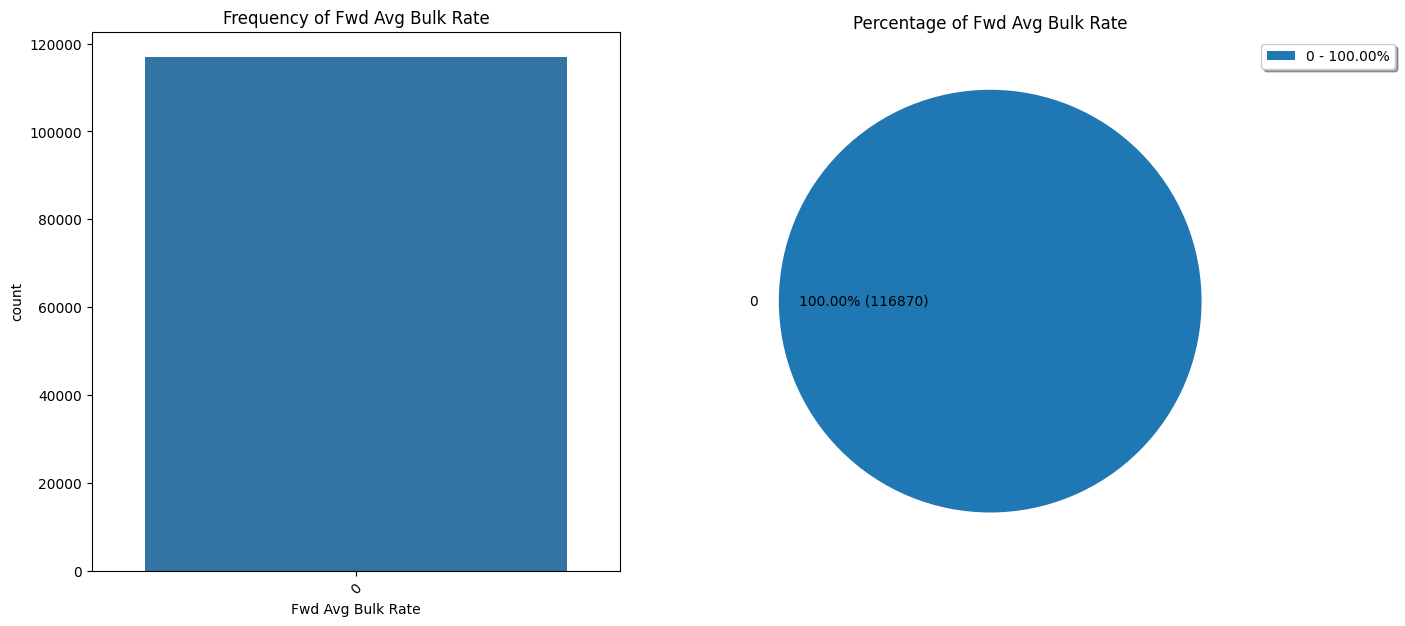

                    Bwd Avg Bytes/Bulk  Ratio
Bwd Avg Bytes/Bulk                           
0                               116870  100.0




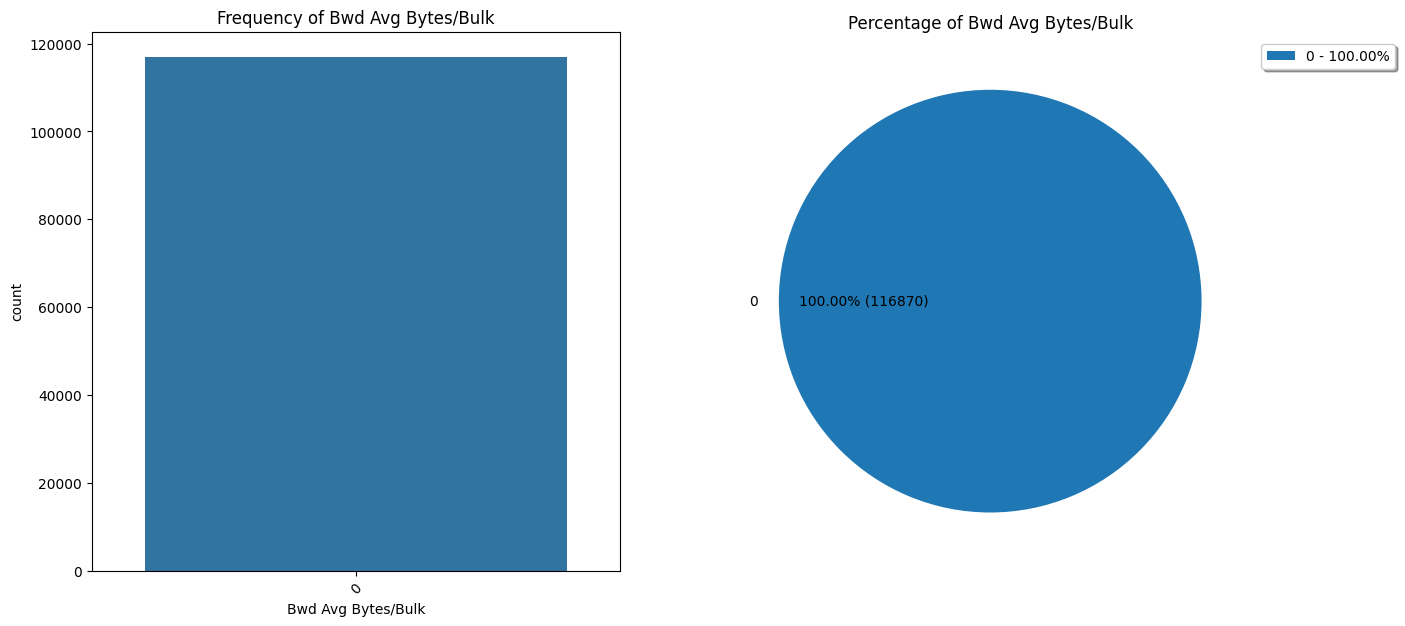

                      Bwd Avg Packets/Bulk  Ratio
Bwd Avg Packets/Bulk                             
0                                   116870  100.0




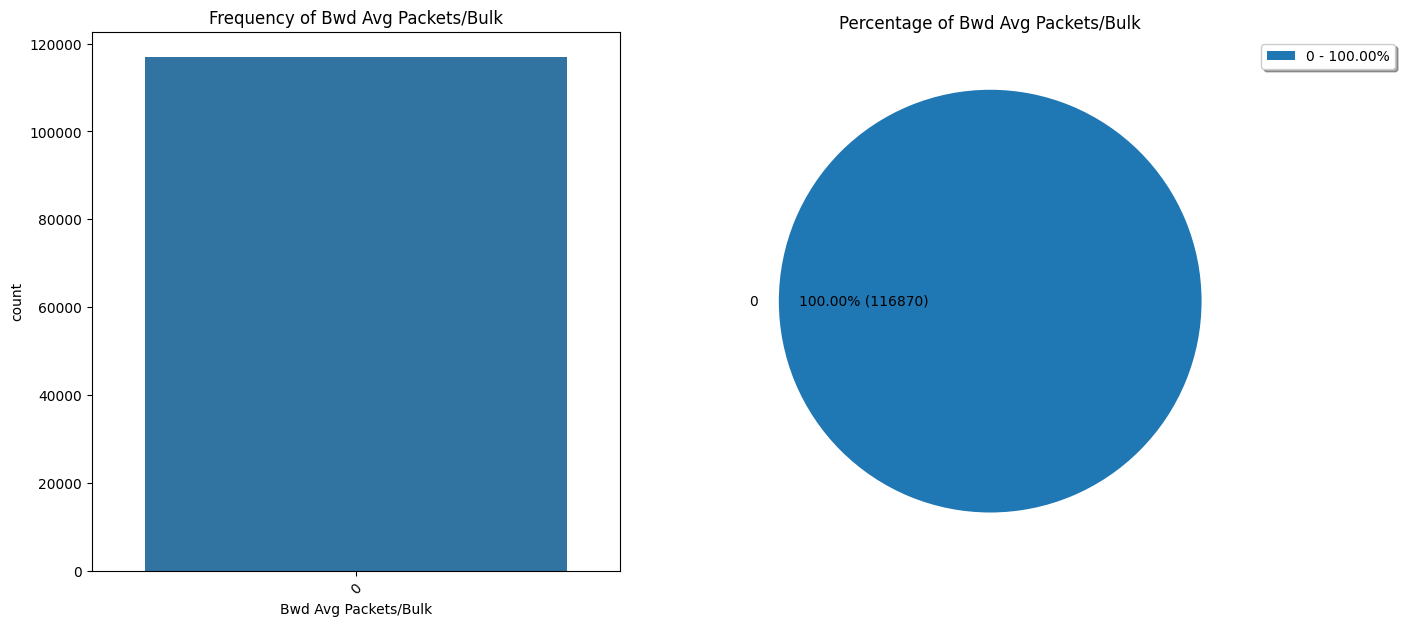

                   Bwd Avg Bulk Rate  Ratio
Bwd Avg Bulk Rate                          
0                             116870  100.0




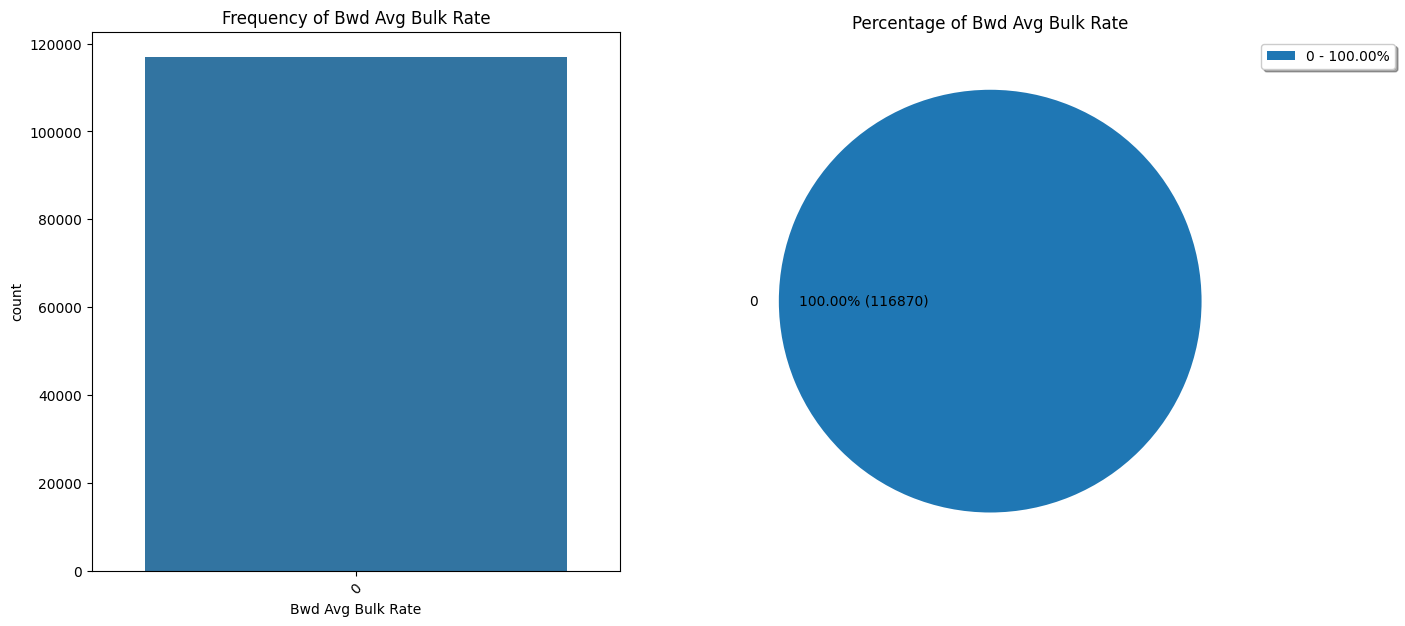

In [21]:
def cat_summary(data, col, plot=False):
    print(pd.DataFrame({col: data[col].value_counts(), "Ratio": data[col].value_counts() / len(data) * 100}))
    print("\n")

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(15, 7))
        plt.subplot(1, 2, 1)
        sns.countplot(x=col, data = data)
        plt.xticks(rotation=45)
        plt.title(f"Frequency of {col}")

        plt.subplot(1, 2, 2)
        values = data[col].value_counts()
        plt.pie(x=values, labels=values.index, autopct= lambda x: "{:.2f}% ({:.0f})".format(x, x/100 * sum(values)))
        plt.legend(labels = ['{} - {:.2f}%'.format(index, value / sum(values) * 100) for index, value in zip(values.index, values)],
                   loc = "upper left",
                   bbox_to_anchor = (1, 1),
                   fancybox = True,
                   shadow = True,
                   ncol=1)
        plt.title(f"Percentage of {col}")
        plt.show(block=True)
for col in cat_cols:
    cat_summary(train_df, col, True)

In [22]:
# Distribution Plots for Numerical Columns

def my_histplot(data, col, ax):
    sns.histplot(x=col, data=data, kde=True, ax=ax)
    ax.set_title(f"Histogram of {col}")

def my_distplot(data, col, ax):
    sns.distplot(data[col], ax=ax)
    ax.set_title(f"Distribution of {col}")

def my_kdeplot(data, col, ax):
    sns.kdeplot(x=col, data=data, ax=ax)
    ax.set_title(f"KDE Plot of {col}")

# Relational Plots for Numerical Columns

def my_scatterplot(data, col, ax):
    sns.scatterplot(x=col, data=data, ax=ax)
    ax.set_title(f"Scatter Plot of {col}")

def my_lineplot(data, col, ax):
    sns.lineplot(x=col, data=data, ax=ax)
    ax.set_title(f"Line Plot of {col}")

# Categorical Plots for Categorical Columns

def my_pie_chart(data, col, ax):
    values = data[col].value_counts()
    ax.pie(x=values, labels=values.index, autopct= lambda x: "{:.2f}% ({:.0f})".format(x, x/100 * sum(values)))
    ax.legend(labels = ['{} - {:.2f}%'.format(index, value / sum(values) * 100) for index, value in zip(values.index, values)],
                loc = "upper left",
                bbox_to_anchor = (1, 1),
                fancybox = True,
                shadow = True,
                ncol=1)
    ax.set_title(f"Pie Chart of {col}")

def my_countplot(data, col, ax):
    sns.countplot(x=col, data=data, ax=ax)
    ax.set_title(f"Count Plot of {col}")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

def my_boxplot(data, col, ax):
    sns.boxplot(y=col, data=data, ax=ax)

def my_violinplot(data, col, ax):
    sns.violinplot(y=col, data=data, ax=ax)

def my_swarmplot(data, col, ax):
    sns.swarmplot(y=col, data=data, ax=ax)

# Matrix Plots for Numerical Columns
def my_headmap(data, size):
    if size: plt.figure(figsize=size)
    sns.heatmap(data.corr(), annot=True, fmt=".1f", cmap="Blues", annot_kws={"size": 12})
    plt.title("Correlation Matrix")
    plt.show()

def my_vsplot(data, normal_col, label_col):
    plt.figure(figsize=(10, 6), dpi=80)
    plt.bar(list(dict(data[normal_col].value_counts()).key()), dict(data[normal_col].value_counts()).values(), color='r')
    plt.bar(list(dict(data[normal_col][data[label_col] == 1].value_counts()).keys()), dict(data[normal_col][data[label_col] == 1].value_counts()).values().keys(), dict(data[normal_col][data[label_col] == 1].value_counts()).values(), color='b')

    plt.xlabel(normal_col)
    plt.ylabel("Counts")
    plt.title(f"{normal_col} vs {label_col}")
    plt.show()

def plot_charts_grid_single_feature(data, plot_func, size=(12,4), n_col = 1):
    if len(data.columns) == 0:
        return
    n_rows = (len(data.columns) + n_col - 1)
    fig, axes = plt.subplots(n_rows, n_col, figsize=(size[0]*n_col, size[1]*n_rows))
    if len(data.columns) == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, col in enumerate(data.columns):
        plot_func(data, col, axes[i])

    for j in range(i+1, n_rows*n_col):
        axes[j].axis("off")
    
    plt.tight_layout()
    plt.show()

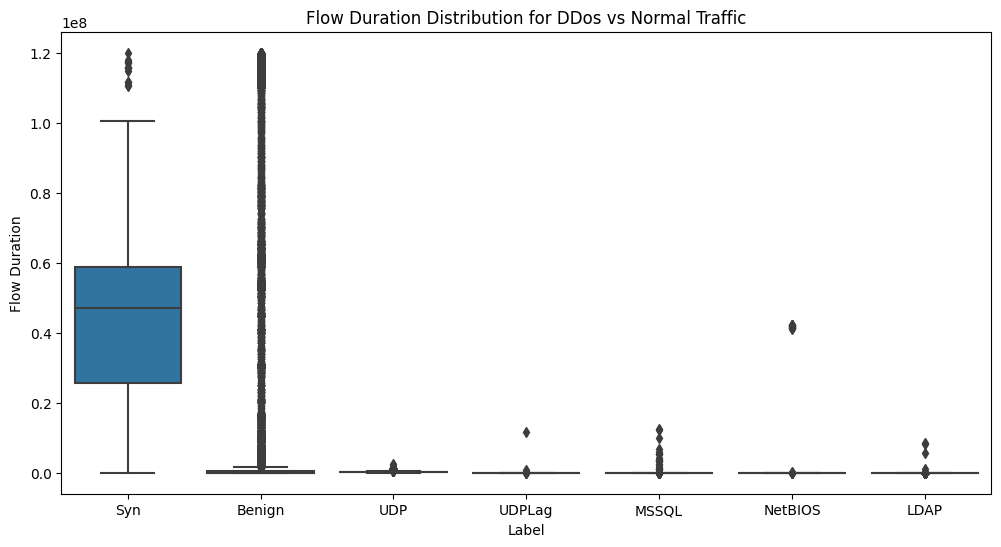

In [23]:
# Boxplot of Flow Duration by Attack Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Label", y="Flow Duration", data=train_df)
plt.title("Flow Duration Distribution for DDos vs Normal Traffic")
plt.show()

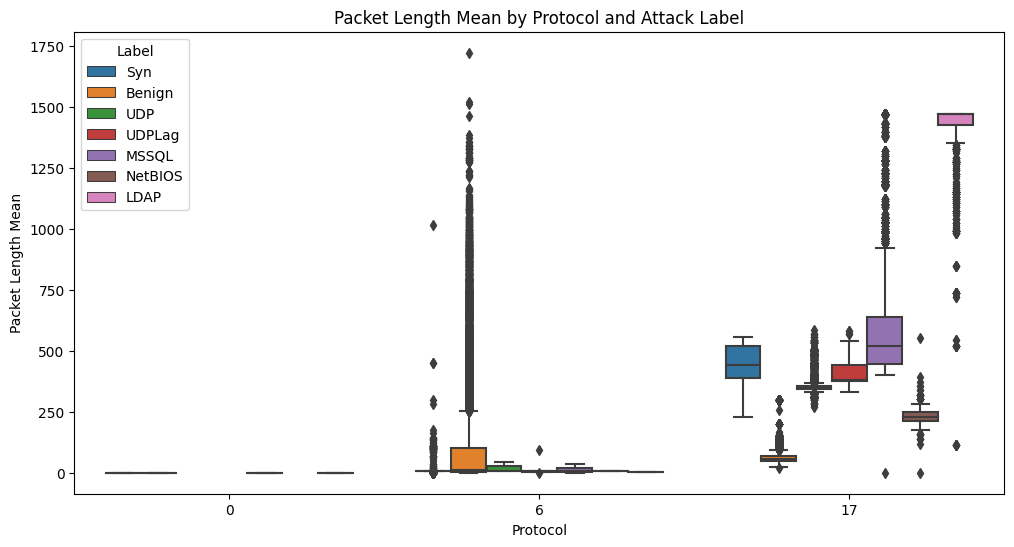

In [24]:
# Boxplot of Packet Length Mean by Protocol and Label
plt.figure(figsize=(12, 6))
sns.boxplot(x="Protocol", y="Packet Length Mean", hue="Label", data=train_df)
plt.title("Packet Length Mean by Protocol and Attack Label")
plt.show()

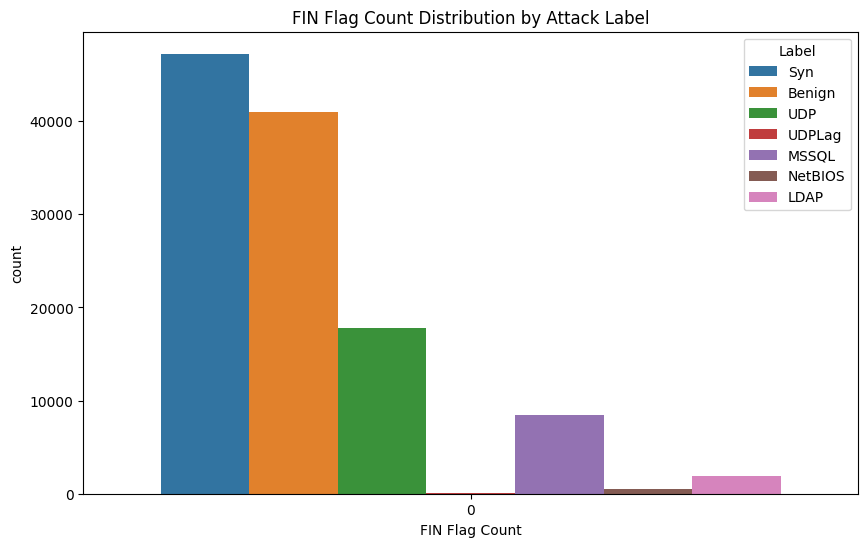

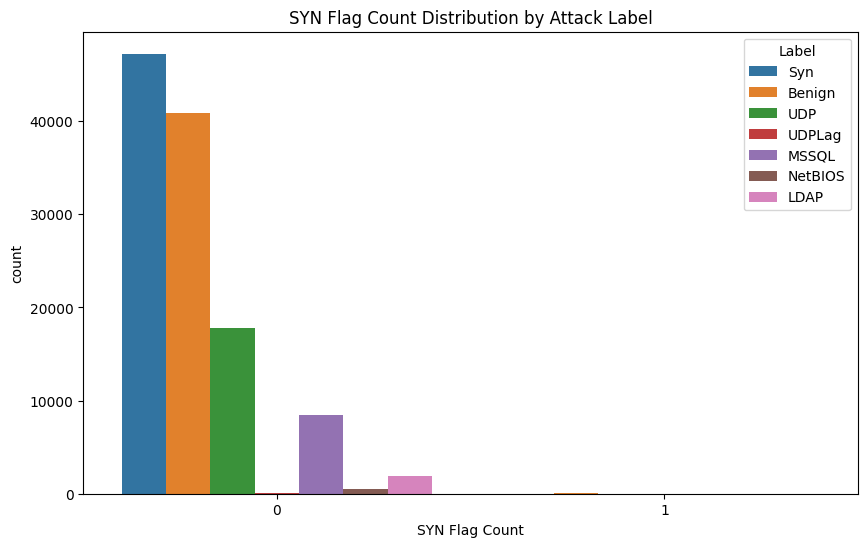

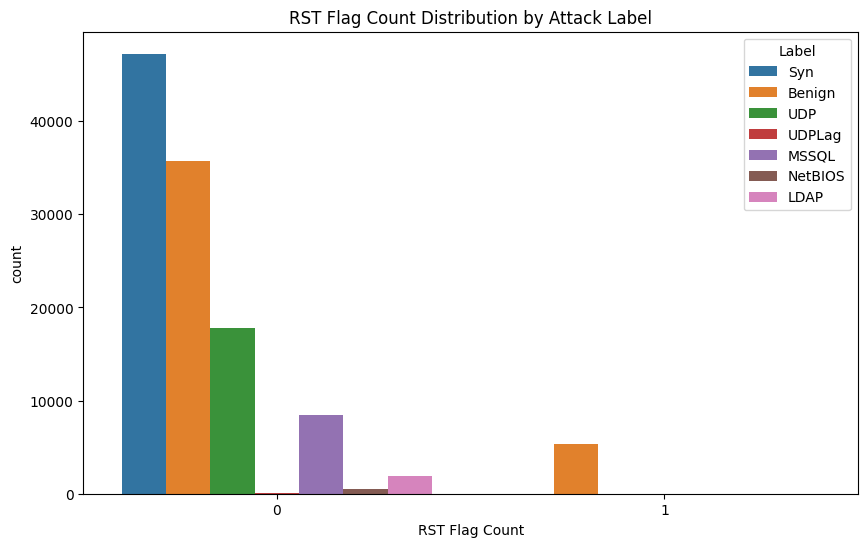

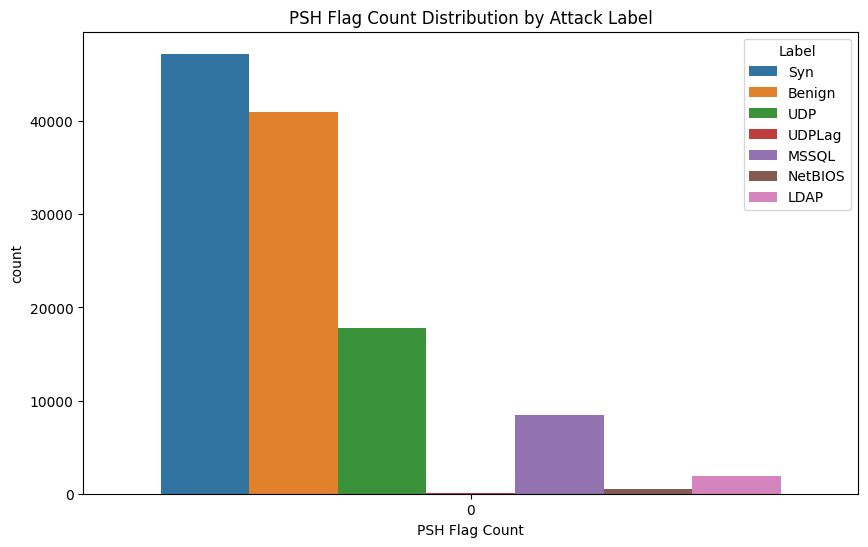

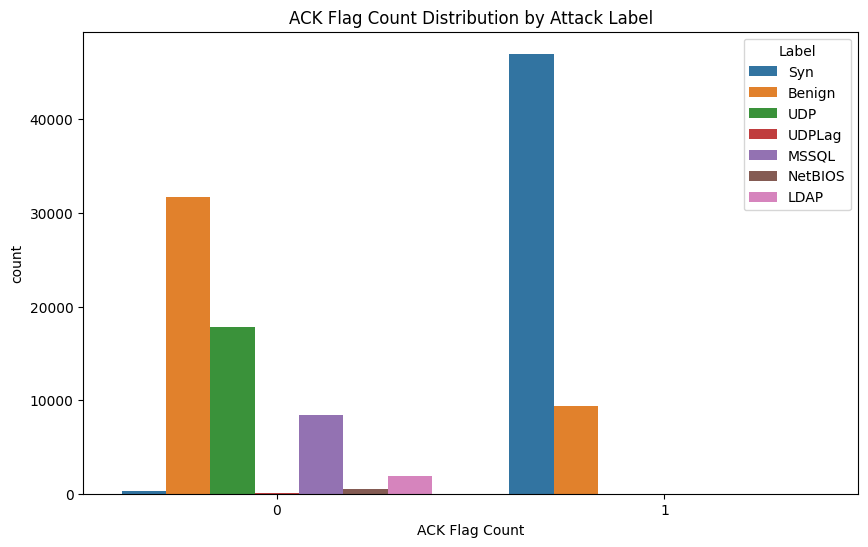

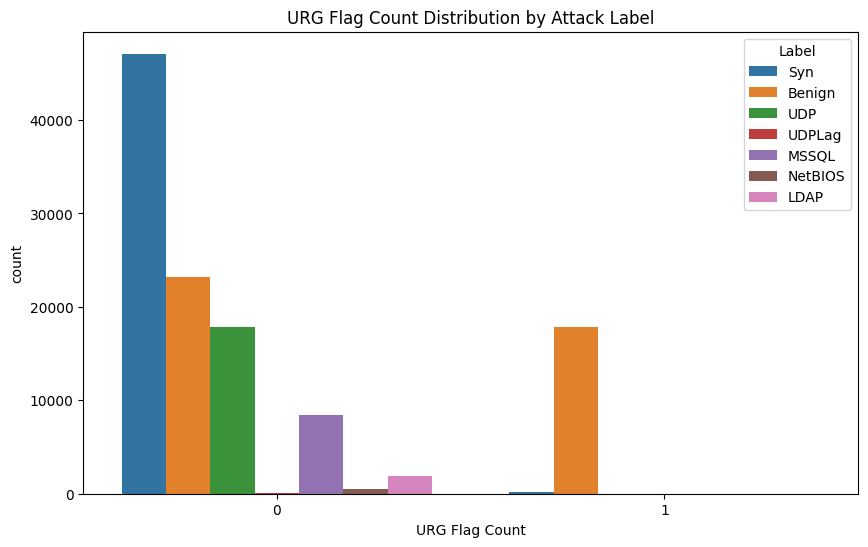

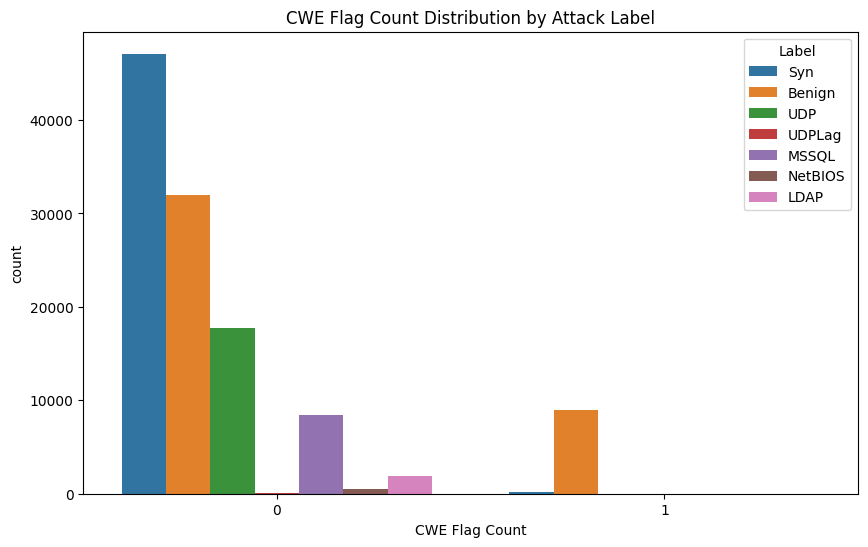

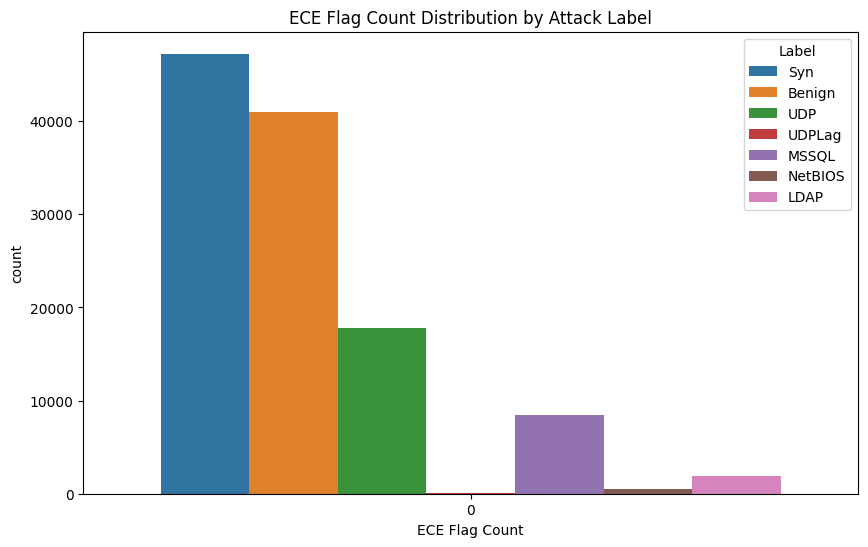

In [25]:
# Counting the number of occurrences of each flag in attack vs normal traffic

flag_cols = [col for col in train_df.columns if "Flag " in col]

for flag in flag_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=flag, hue="Label", data=train_df)
    plt.title(f"{flag} Distribution by Attack Label")
    plt.show()

In [26]:
# Features with a single unique value
single_val_cols = [col for col in train_df.columns if train_df[col].nunique() == 1]
single_val_cols

['Bwd PSH Flags',
 'Fwd URG Flags',
 'Bwd URG Flags',
 'FIN Flag Count',
 'PSH Flag Count',
 'ECE Flag Count',
 'Fwd Avg Bytes/Bulk',
 'Fwd Avg Packets/Bulk',
 'Fwd Avg Bulk Rate',
 'Bwd Avg Bytes/Bulk',
 'Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate']

In [27]:
# Remove columns with a single unique value
train_df.drop(single_val_cols, axis=1, inplace = True)
test_df.drop(single_val_cols, axis=1, inplace = True)

In [28]:
# Shape of the dataset after removing columns with a single unique value
train_df.shape, test_df.shape

((116870, 66), (38922, 66))

In [ ]:
# Select only numeric columns
numerical_df = train_df.select_dtypes(include=[np.number])

# Calculate the correlation matrix
corr_matrix = numerical_df.corr().abs()

# Generate a boolean mask for the upper triangle
mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(mask)

# Find the columns with correlation of 0.8 or higher
high_corr_cols = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.8)]

# Display the number of highly correlated columns and their names
print(f"Total number of highly correlated columns: {len(high_corr_cols)}")
print("Highly correlated columns are:", high_corr_cols)

Total number of highly correlated columns: 33
Highly correlated columns are: ['Bwd Packets Length Total', 'Fwd Packet Length Mean', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Max', 'Fwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance', 'RST Flag Count', 'Avg Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Fwd Seg Size Min', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Max', 'Idle Min']


In [30]:
# Remove highly correlated columns from the dataset
train_df.drop(high_corr_cols, axis=1, inplace=True)
test_df.drop(high_corr_cols, axis=1, inplace=True)

In [31]:
# Shape of the dataset after removing highly correlated columns
train_df.shape, test_df.shape

((116870, 33), (38922, 33))

In [32]:
X_train, X_val, y_train, y_val = train_test_split(train_df.drop("Label", axis=1), train_df["Label"], test_size=0.2, random_state=42)
X_test, y_test = test_df.drop("Label", axis=1), test_df["Label"]

In [33]:
X_train.shape, X_val.shape, X_test.shape

((93496, 32), (23374, 32), (38922, 32))

In [34]:
# Encode the target variable

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)

# Label mapping for the target variable
label_map = {index: Label for index, Label in enumerate(le.classes_)}

In [35]:
label_map

{0: 'Benign',
 1: 'LDAP',
 2: 'MSSQL',
 3: 'NetBIOS',
 4: 'Syn',
 5: 'UDP',
 6: 'UDPLag'}

In [36]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [37]:
from sklearn.model_selection import train_test_split

# Create a shuffled and stratified split for each client
client_data = []
client_labels = []

for _ in range(5):
    X_part, _, y_part, _ = train_test_split(X_train, y_train, test_size=0.8, stratify=y_train, random_state=np.random.randint(1000))
    client_data.append(X_part)
    client_labels.append(y_part)

# Check the shape and class distribution for each client
for i in range(5):
    unique, counts = np.unique(client_labels[i], return_counts=True)
    print(f"Client {i+1}: {client_data[i].shape}, Class Distribution: {dict(zip(unique, counts))}")


Client 1: (18699, 32), Class Distribution: {0: 6553, 1: 301, 2: 1364, 3: 78, 4: 7544, 5: 2851, 6: 8}
Client 2: (18699, 32), Class Distribution: {0: 6553, 1: 301, 2: 1364, 3: 78, 4: 7544, 5: 2851, 6: 8}
Client 3: (18699, 32), Class Distribution: {0: 6553, 1: 301, 2: 1364, 3: 78, 4: 7544, 5: 2851, 6: 8}
Client 4: (18699, 32), Class Distribution: {0: 6553, 1: 301, 2: 1364, 3: 78, 4: 7544, 5: 2851, 6: 8}
Client 5: (18699, 32), Class Distribution: {0: 6553, 1: 301, 2: 1364, 3: 78, 4: 7544, 5: 2851, 6: 8}


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, PReLU
from tensorflow.keras.optimizers import Adam

# FedProx Hyperparameters
mu = 0.01  # FedProx regularization parameter
momentum = 0.9  # Momentum factor for weight updates
batch_size = 32  # Batch size for training

# Create local model function
def create_local_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        PReLU(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Dense(16, activation='relu'),
        PReLU(),
        Dense(len(label_map), activation='softmax')  
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize global model
global_model = create_local_model()
previous_weights = global_model.get_weights()

num_rounds = 25
for round_num in range(num_rounds):
    print(f"\n--- FedProx Round {round_num + 1} ---\n")
    
    client_weight_diffs = []

    for i in range(5):
        print(f"Training on Client {i + 1}...")

        local_model = create_local_model()
        local_model.set_weights(global_model.get_weights())

        # Train local model with batch size
        local_model.fit(client_data[i], client_labels[i], epochs=3, batch_size=batch_size, verbose=0)
        
        # Evaluate local model
        loss, accuracy = local_model.evaluate(client_data[i], client_labels[i], batch_size=batch_size, verbose=0)
        print(f"Client {i + 1} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")
        
        # Compute Proximal Term (FedProx Regularization)
        local_weights = local_model.get_weights()
        global_weights = global_model.get_weights()

        prox_term = [w1 - w2 for w1, w2 in zip(local_weights, global_weights)]
        updated_weights = [w1 - mu * w2 for w1, w2 in zip(local_weights, prox_term)]
        
        client_weight_diffs.append(updated_weights)

    # Momentum-Based Aggregation
    new_weights = [
        (momentum * prev) + ((1 - momentum) * np.median([client_weight_diffs[j][i] for j in range(5)], axis=0))
        for i, prev in enumerate(previous_weights)
    ]

    # Update global model
    global_model.set_weights(new_weights)
    previous_weights = new_weights  # Save previous weights for momentum update

    # Evaluate the global model
    loss, accuracy = global_model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
    print(f"Global Model - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

print("\nFedProx Training Completed.")



--- FedProx Round 1 ---

Training on Client 1...
Client 1 - Loss: 0.0847, Accuracy: 0.9750
Training on Client 2...
Client 2 - Loss: 0.0774, Accuracy: 0.9755
Training on Client 3...
Client 3 - Loss: 0.0804, Accuracy: 0.9732
Training on Client 4...
Client 4 - Loss: 0.0894, Accuracy: 0.9732
Training on Client 5...
Client 5 - Loss: 0.0847, Accuracy: 0.9727
Global Model - Loss: 1.9388, Accuracy: 0.0746

--- FedProx Round 2 ---

Training on Client 1...
Client 1 - Loss: 0.0838, Accuracy: 0.9751
Training on Client 2...
Client 2 - Loss: 0.0884, Accuracy: 0.9722
Training on Client 3...
Client 3 - Loss: 0.0785, Accuracy: 0.9756
Training on Client 4...
Client 4 - Loss: 0.0881, Accuracy: 0.9722
Training on Client 5...
Client 5 - Loss: 0.0852, Accuracy: 0.9768
Global Model - Loss: 1.8407, Accuracy: 0.1157

--- FedProx Round 3 ---

Training on Client 1...
Client 1 - Loss: 0.0786, Accuracy: 0.9750
Training on Client 2...
Client 2 - Loss: 0.0745, Accuracy: 0.9789
Training on Client 3...
Client 3 - Los

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
y_val_pred1 = np.argmax(global_model.predict(X_val), axis=1)  # Convert probabilities to class labels

test_accuracy1 = accuracy_score(y_val, y_val_pred1)  # Compare with true labels

print(f"Accuracy: {test_accuracy1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred1, target_names=label_map.values()))

731/731 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Accuracy: 0.9822

Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      1.00      1.00      8215
        LDAP       0.84      0.93      0.88       379
       MSSQL       0.87      0.96      0.91      1612
     NetBIOS       0.79      0.25      0.38        87
         Syn       1.00      0.99      1.00      9526
         UDP       0.98      0.95      0.97      3542
      UDPLag       0.00      0.00      0.00        13

    accuracy                           0.98     23374
   macro avg       0.78      0.73      0.73     23374
weighted avg       0.98      0.98      0.98     23374



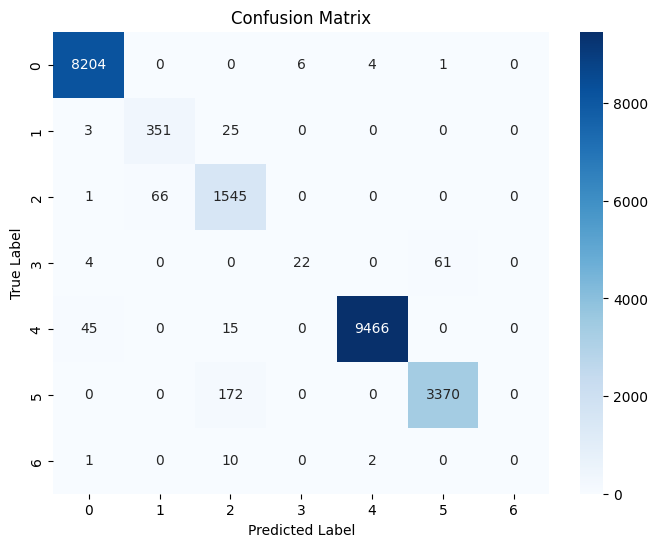

In [40]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred1)



# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            xticklabels=list(label_map.keys()), 
            yticklabels=list(label_map.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [42]:
import numpy as np

# Get input shape from training data
input_shape = X_train.shape[1]

# Generate a random input vector (same shape as a training sample)
random_input = np.random.rand(1, input_shape)

# Predict using the global model
prediction = global_model.predict(random_input)

# Get predicted class
predicted_class = np.argmax(prediction, axis=1)[0]

# Optionally, map class index to label if label_map exists
class_name = label_map[predicted_class] if isinstance(label_map, dict) else predicted_class

print("Random Input:", random_input)
print("Predicted Class Index:", predicted_class)
print("Predicted Class Name:", class_name)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Random Input: [[0.14298658 0.55296027 0.87343631 0.81805774 0.20341646 0.55662533
  0.36293513 0.31575359 0.33308381 0.62259655 0.88559618 0.56985241
  0.65900887 0.38549662 0.74225611 0.87891136 0.83712009 0.52392178
  0.60648812 0.79360637 0.68614005 0.37683255 0.30641797 0.3438141
  0.53543179 0.02570594 0.66896854 0.79716488 0.57354042 0.44230094
  0.46363138 0.14824569]]
Predicted Class Index: 0
Predicted Class Name: Benign


2338/2338 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8253 - loss: 0.5131 - val_accuracy: 0.9819 - val_loss: 0.0675
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4067 - loss: 8.2984

Test Loss: 3.4675, Test Accuracy: 0.7319
1217/1217 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10847
           1       0.75      0.98      0.85      1440
           2       0.89      0.93      0.91      6212
           3       0.00      0.00      0.00       598
           4       0.07      1.00      0.14       533
           5       0.80      0.95      0.87     10420
           6       0.00      0.00      0.00      8872

    accuracy                           0.73     38922
   macro avg       0.50      0.69      0.54     38922
weighted avg       0.66      0.73      0.69     38922



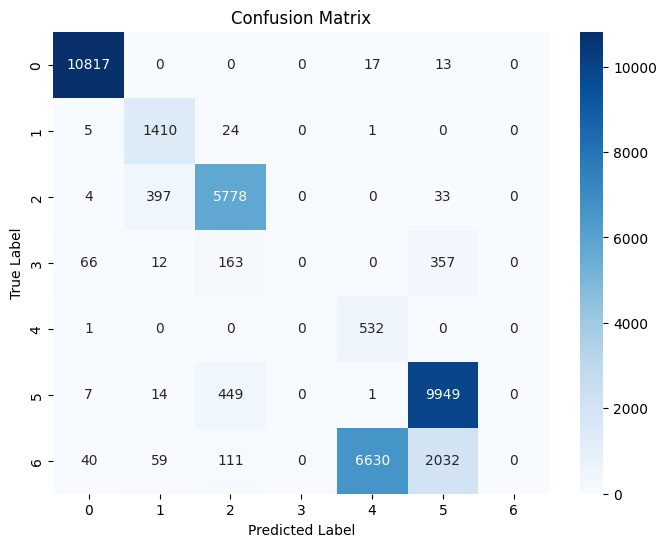

In [41]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Define the ANN model
def create_ann_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(len(label_map), activation='softmax')  # Output layer with number of classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the model
ann_model = create_ann_model()

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model on the full dataset
ann_model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = ann_model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred = np.argmax(ann_model.predict(X_test), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=[str(label) for label in label_map.keys()]))


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            xticklabels=list(label_map.keys()), 
            yticklabels=list(label_map.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
